**Bloque 1: Instalación de dependencias**

Explicación:
El objetivo de este bloque es instalar la librería imblearn, que usaremos más adelante para aplicar SMOTE (Synthetic Minority Oversampling Technique). SMOTE es una técnica para manejar el desbalance de clases en la variable objetivo Exited (clientes que abandonan vs. los que no), generando datos sintéticos para la clase minoritaria (Exited=1). Esto mejora el rendimiento de los modelos de machine learning al entrenar con un dataset más equilibrado.

En Microsoft Fabric, usamos el comando mágico %pip install para instalar librerías en el entorno del notebook. Este comando reinicia el kernel de PySpark después de la instalación para asegurarse de que los cambios se apliquen correctamente. Por eso, es importante ejecutar esta celda primero y esperar a que termine antes de continuar con el resto del notebook.

In [2]:
# Instalación de dependencias
# Instalamos imblearn para usar SMOTE, que maneja el desbalance de clases.
# Esto reiniciará el kernel de PySpark, así que ejecuta esta celda primero y espera a que termine.
%pip install imblearn
# Nota: Si imblearn ya está instalado, esta celda no tendrá efecto. El reinicio del kernel es necesario para aplicar cambios.

StatementMeta(, b7bb6db7-91b2-49a8-ab30-e6be7693453e, 15, Finished, Available, Finished)


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.



**Bloque 2: Carga de datos**

Explicación:
El objetivo de este bloque es cargar el dataset churn.csv desde el lakehouse churn_lakehouse en Microsoft Fabric, utilizando la ruta ABFS: abfss://Fabric@onelake.dfs.fabric.microsoft.com/churn_lakehouse.Lakehouse/Files/data/churn.csv. Usaremos Spark para leer el archivo CSV, ya que es una herramienta eficiente para manejar grandes volúmenes de datos en Fabric. La opción header="true" asegura que la primera fila del archivo se interprete como los nombres de las columnas.

Además, mostraremos una vista previa de los datos con display(df) para inspeccionar las primeras filas y confirmar que el dataset se cargó correctamente. También inicializaremos un temporizador con time.time() para medir el tiempo total de ejecución del notebook, lo que nos permitirá evaluar la eficiencia del proceso más adelante.

In [3]:
# Carga de datos
# Cargamos el archivo churn.csv desde el lakehouse usando Spark.
# El dataset contiene información de clientes de un banco, con columnas como puntaje crediticio, ubicación, género, edad, saldo, productos contratados, y si el cliente abandonó el servicio (Exited).
# Usamos Spark para manejar datos eficientemente y mostramos una vista previa con display(df).

# Definir la ruta del dataset usando ABFS
DATA_PATH = "abfss://Fabric@onelake.dfs.fabric.microsoft.com/churn_lakehouse.Lakehouse/Files/data/churn.csv"

# Iniciar temporizador para medir el tiempo de ejecución
import time
ts = time.time()

# Cargar el dataset
df = spark.read.format("csv").option("header", "true").load(DATA_PATH)
display(df)

StatementMeta(, b7bb6db7-91b2-49a8-ab30-e6be7693453e, 17, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 487a93b3-8db3-4b18-8a5b-4d29d58d8904)

**Bloque 3: Exploración del esquema y columnas**

Explicación:
En este bloque, nuestro objetivo es conocer mejor el dataset churn.csv que cargamos en el Bloque 2. Esto es crucial para cualquier proyecto de ciencia de datos, ya que nos permite:

Identificar los tipos de datos de cada columna y verificar si son correctos (por ejemplo, si CreditScore debería ser un entero en lugar de un string).
Obtener estadísticas básicas (como promedio, mínimo, máximo) para entender la distribución de los datos.
Revisar los valores únicos en columnas categóricas (como Geography o Gender) para identificar posibles categorías y desbalances.
Detectar valores faltantes que podrían requerir manejo en la etapa de limpieza.
El dataset churn.csv tiene 1000 filas y 14 columnas, y fue cargado como un Spark DataFrame (df). Convertiremos este DataFrame a pandas para facilitar el análisis exploratorio, ya que pandas ofrece funciones más convenientes para este propósito. También mostraremos los resultados de forma clara para documentar el proceso.


In [6]:
# Exploración del esquema y columnas
# Inspeccionamos el esquema, estadísticas básicas, y valores únicos para entender mejor los datos.

# Mostrar columnas y tipos de datos del DataFrame de Spark
print("Columnas del DataFrame:", df.columns)
print("Tipos de datos (Spark):")
for col, dtype in df.dtypes:
    print(f"{col}: {dtype}")

# Convertir a pandas para análisis más detallado
df_pandas = df.toPandas()

# Mostrar estadísticas básicas (promedio, min, max, etc.)
print("\nEstadísticas básicas del DataFrame:")
print(df_pandas.describe(include='all'))

# Mostrar valores únicos y conteo para columnas categóricas
cat_vars = ['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']
for var in cat_vars:
    print(f"\nValores únicos en {var}:", df_pandas[var].unique())
    print(f"Conteo de valores en {var}:")
    print(df_pandas[var].value_counts())
    print("---")

# Verificar valores faltantes
print("\nValores faltantes por columna:")
print(df_pandas.isnull().sum())

StatementMeta(, b7bb6db7-91b2-49a8-ab30-e6be7693453e, 20, Finished, Available, Finished)

Columnas del DataFrame: ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
Tipos de datos (Spark):
RowNumber: string
CustomerId: string
Surname: string
CreditScore: string
Geography: string
Gender: string
Age: string
Tenure: string
Balance: string
NumOfProducts: string
HasCrCard: string
IsActiveMember: string
EstimatedSalary: string
Exited: string

Estadísticas básicas del DataFrame:
       RowNumber CustomerId Surname CreditScore Geography Gender    Age  \
count      10000      10000   10000       10000     10000  10000  10000   
unique     10000      10000    2932         460         3      2     70   
top            1   15634602   Smith         850    France   Male     37   
freq           1          1      32         233      5014   5457    478   

       Tenure Balance NumOfProducts HasCrCard IsActiveMember EstimatedSalary  \
count   10000   10000     

**Bloque 4: Limpieza de datos**

Explicación:
En este bloque, prepararemos el dataset churn.csv para las etapas posteriores (visualización, ingeniería de características, y modelado) mediante un proceso de limpieza. La limpieza de datos es un paso crucial en cualquier proyecto de ciencia de datos, ya que asegura que el dataset esté en un formato adecuado para el análisis. Basado en los resultados del Bloque 3, identificamos los siguientes puntos a abordar:

Tipos de datos incorrectos:
Todas las columnas se cargaron como string (por ejemplo, CreditScore, Age, Balance), pero deberían tener tipos numéricos para análisis y modelado:
CreditScore, Age, Tenure, NumOfProducts, HasCrCard, IsActiveMember, Exited → int.
Balance, EstimatedSalary → float.
Convertiremos estas columnas a los tipos correctos.
Columnas irrelevantes:
RowNumber, CustomerId, y Surname no aportan valor predictivo para el modelado (son identificadores o datos no relevantes). Las eliminaremos.
Duplicados:
Verificaremos si hay filas duplicadas basadas en CustomerId (ya que cada cliente debe ser único) y las eliminaremos si existen.
Valores faltantes:
No hay valores faltantes según el Bloque 3 (isnull().sum() mostró 0 para todas las columnas), así que no necesitamos manejar valores nulos.
Conversión a categorías:
Para optimizar el uso de memoria y facilitar el análisis, convertiremos columnas categóricas como NumOfProducts, HasCrCard, IsActiveMember, y Exited al tipo category en pandas.
Guardado como tabla Delta:
Guardaremos el DataFrame limpio como una tabla Delta en el lakehouse (Tables/df_clean) para usarlo en las siguientes etapas. Las tablas Delta son ideales en Fabric porque permiten un acceso eficiente y versionado de los datos.
El DataFrame limpio (df_clean) tendrá menos columnas (11 en lugar de 14, tras eliminar RowNumber, CustomerId, Surname) y tipos de datos corregidos, listo para análisis posteriores.


In [7]:
# Limpieza de datos
# Preparamos el DataFrame para análisis: corregimos tipos de datos, eliminamos duplicados y columnas irrelevantes, y guardamos como tabla Delta.

def clean_data(df):
    # Convertir a pandas para limpieza
    df_pandas = df.toPandas()
    
    # Corregir tipos de datos
    df_pandas['CreditScore'] = df_pandas['CreditScore'].astype(int)
    df_pandas['Age'] = df_pandas['Age'].astype(int)
    df_pandas['Tenure'] = df_pandas['Tenure'].astype(int)
    df_pandas['Balance'] = df_pandas['Balance'].astype(float)
    df_pandas['NumOfProducts'] = df_pandas['NumOfProducts'].astype(int)
    df_pandas['HasCrCard'] = df_pandas['HasCrCard'].astype(int)
    df_pandas['IsActiveMember'] = df_pandas['IsActiveMember'].astype(int)
    df_pandas['EstimatedSalary'] = df_pandas['EstimatedSalary'].astype(float)
    df_pandas['Exited'] = df_pandas['Exited'].astype(int)
    
    # Eliminar filas duplicadas basadas en CustomerId
    df_pandas.drop_duplicates(subset=['CustomerId'], inplace=True)
    
    # Eliminar columnas irrelevantes: RowNumber, CustomerId, Surname
    df_pandas.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)
    
    # Convertir columnas categóricas a tipo category
    df_pandas['Geography'] = df_pandas['Geography'].astype('category')
    df_pandas['Gender'] = df_pandas['Gender'].astype('category')
    df_pandas['NumOfProducts'] = df_pandas['NumOfProducts'].astype('category')
    df_pandas['HasCrCard'] = df_pandas['HasCrCard'].astype('category')
    df_pandas['IsActiveMember'] = df_pandas['IsActiveMember'].astype('category')
    df_pandas['Exited'] = df_pandas['Exited'].astype('category')
    
    return df_pandas

# Limpiar el DataFrame
df_clean = clean_data(df)

# Mostrar primeras filas y tipos de datos del DataFrame limpio
print("Primeras filas de df_clean:")
print(df_clean.head())
print("\nTipos de datos de df_clean:")
print(df_clean.dtypes)

# Guardar como tabla Delta
spark.createDataFrame(df_clean).write.format("delta").mode("overwrite").save("Tables/df_clean")

StatementMeta(, b7bb6db7-91b2-49a8-ab30-e6be7693453e, 21, Finished, Available, Finished)

Primeras filas de df_clean:
   CreditScore Geography  Gender  Age  Tenure    Balance NumOfProducts  \
0          619    France  Female   42       2       0.00             1   
1          608     Spain  Female   41       1   83807.86             1   
2          502    France  Female   42       8  159660.80             3   
3          699    France  Female   39       1       0.00             2   
4          850     Spain  Female   43       2  125510.82             1   

  HasCrCard IsActiveMember  EstimatedSalary Exited  
0         1              1        101348.88      1  
1         0              1        112542.58      0  
2         1              0        113931.57      1  
3         0              0         93826.63      0  
4         1              1         79084.10      0  

Tipos de datos de df_clean:
CreditScore           int64
Geography          category
Gender             category
Age                   int64
Tenure                int64
Balance             float64
NumOfProduct

**Bloque 5: Visualización**

Explicación:
En este bloque, exploraremos visualmente el dataset limpio (df_clean) para entender mejor las relaciones entre las variables y la variable objetivo Exited (si el cliente abandonó o no). La visualización es un paso clave en el análisis exploratorio de datos, ya que nos permite identificar patrones, tendencias, y posibles correlaciones que guiarán las etapas posteriores (como ingeniería de características y modelado). Usaremos las librerías seaborn y matplotlib, que son ideales para generar gráficos claros y atractivos.

Vamos a crear dos tipos de gráficos:

Gráficos de barras para variables categóricas:
Analizaremos cómo se distribuyen las variables categóricas (Geography, Gender, NumOfProducts, HasCrCard, IsActiveMember) en relación con Exited.
Esto nos ayudará a ver, por ejemplo, si los clientes de ciertas regiones (Geography) tienen más probabilidad de abandonar, o si el género (Gender) influye en la tasa de abandono.
Histogramas para variables numéricas:
Exploraremos la distribución de las variables numéricas (CreditScore, Age, Tenure, Balance, EstimatedSalary) y cómo se relacionan con Exited.
Esto nos permitirá identificar patrones, como si los clientes más jóvenes tienden a abandonar más, o si un saldo bajo está asociado con una mayor tasa de abandono.
Guardado de gráficos:

Los gráficos se guardarán en la carpeta results/ del lakehouse, usando la ruta ABFS abfss://Fabric@onelake.dfs.fabric.microsoft.com/churn_lakehouse.Lakehouse/Files/results/.


StatementMeta(, b7bb6db7-91b2-49a8-ab30-e6be7693453e, 27, Finished, Available, Finished)

Variable dependiente (target): Exited
Variables categóricas: ['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
Variables numéricas: ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']


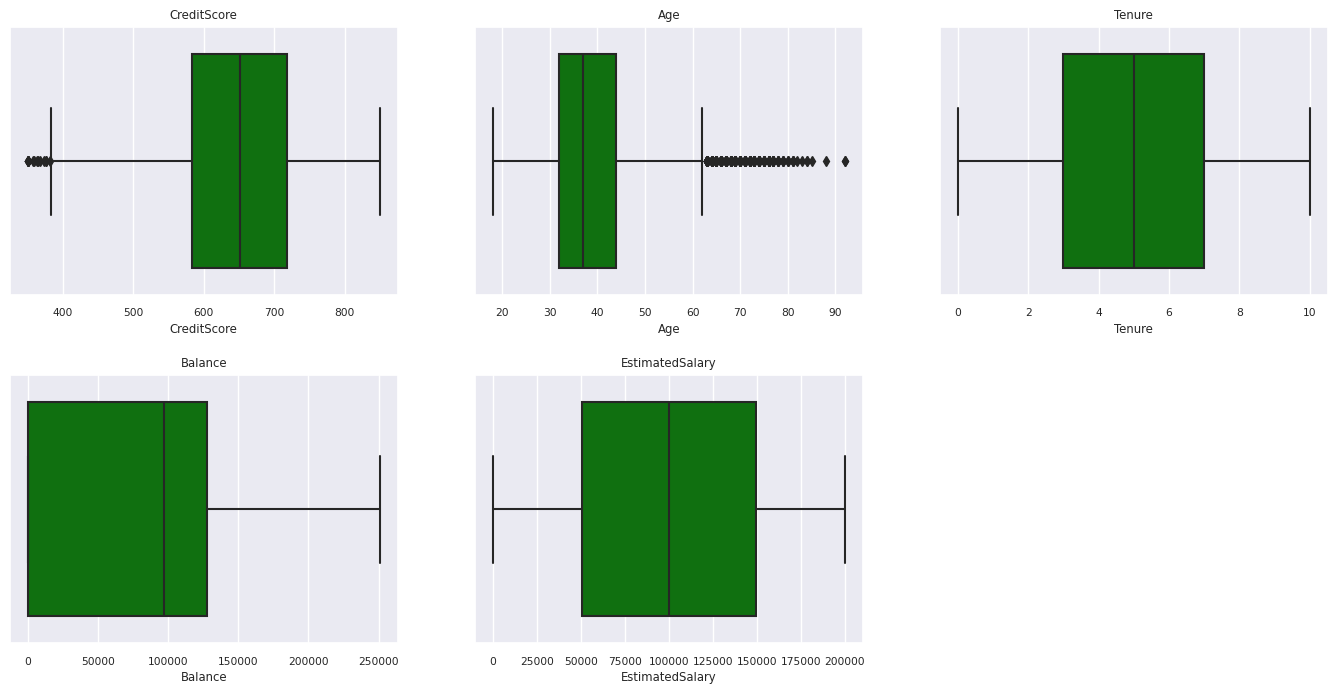

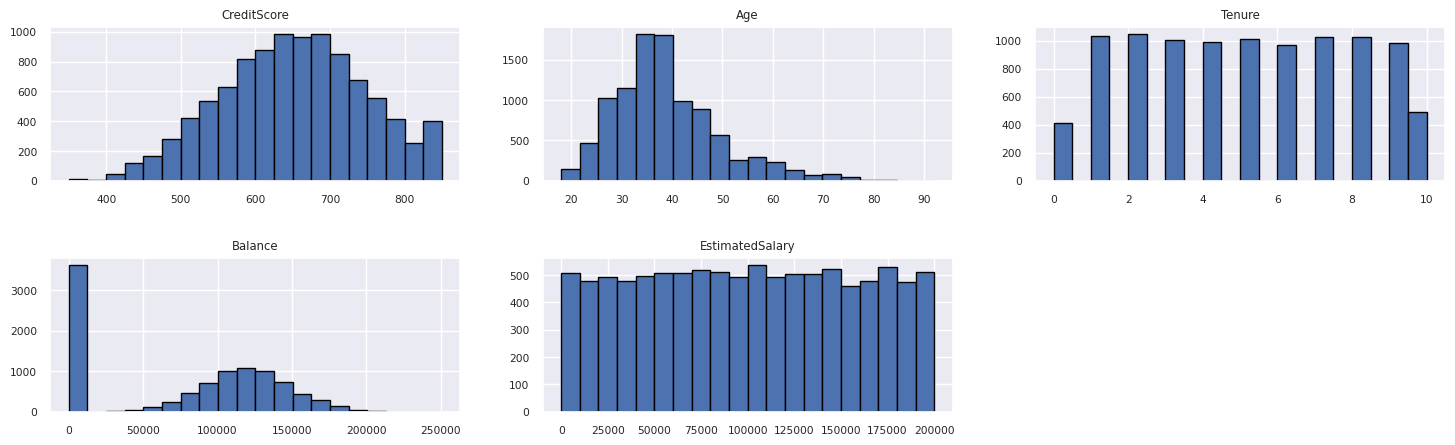

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass obs

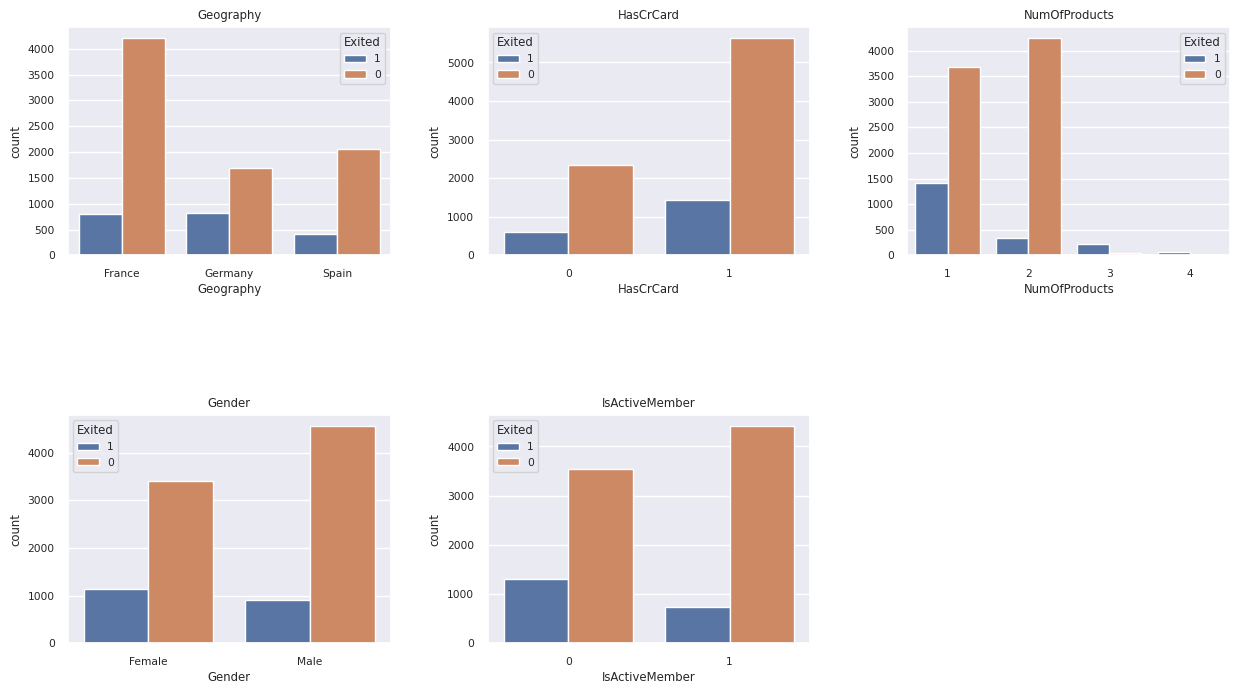

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass obs

In [13]:
# Visualización
# Usamos seaborn y matplotlib para explorar los datos visualmente.
# Generamos boxplots, histogramas y gráficos de barras para variables categóricas.
# Mostramos los gráficos en el notebook y los guardamos en la carpeta results/.

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import rc, rcParams
import numpy as np
import pandas as pd
import itertools
from io import BytesIO

# Configurar estilo visual
sns.set_theme(style="whitegrid", palette="tab10", rc={'figure.figsize':(9,6)})
sns.set(font_scale=0.7)

# Verificar que df_clean tenga datos
if df_clean.empty:
    raise ValueError("El DataFrame df_clean está vacío. Verifica los pasos anteriores.")

# Determinar el target, variables categóricas y numéricas
dependent_variable_name = "Exited"
print("Variable dependiente (target):", dependent_variable_name)

# Variables categóricas: tipo object o category, excluyendo Exited
categorical_variables = [col for col in df_clean.columns if df_clean[col].dtype.name in ['object', 'category']
                         and col not in "Exited"]
print("Variables categóricas:", categorical_variables)

# Variables numéricas: especificamos explícitamente
numeric_variables = [col for col in ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
                     if col in df_clean.columns]
print("Variables numéricas:", numeric_variables)

# Crear boxplots para variables numéricas (resumen de cinco números: min, Q1, mediana, Q3, max)
df_num_cols = df_clean[numeric_variables]
fig, axes = plt.subplots(nrows=2, ncols=3, gridspec_kw=dict(hspace=0.3), figsize=(17,8))
for ax, col in zip(axes.flatten(), df_num_cols.columns):
    sns.boxplot(x=df_num_cols[col], color='green', ax=ax)
    ax.set_title(col)
if len(df_num_cols.columns) < 6:  # Eliminar ejes vacíos si hay menos de 6 variables
    fig.delaxes(axes[1,2])
plt.show()

# Guardar boxplots usando BytesIO y Spark
for col in df_num_cols.columns:
    plt.figure(figsize=(9,6))
    sns.boxplot(x=df_num_cols[col], color='green')
    plt.title(f'Boxplot de {col}')
    plt.xlabel(col)
    # Guardar en un búfer de memoria
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()
    buf.seek(0)
    # Convertir el búfer a un RDD para usar Spark
    image_data = buf.read()
    image_rdd = spark.sparkContext.parallelize([image_data])
    # Guardar en OneLake usando Spark
    onelake_path = f'abfss://Fabric@onelake.dfs.fabric.microsoft.com/churn_lakehouse.Lakehouse/Files/results/boxplot_{col.lower()}.png'
    image_rdd.saveAsTextFile(onelake_path)

# Crear histogramas para variables numéricas
columns = df_num_cols.columns
fig = plt.figure(figsize=(18, 8))
length = len(columns)
for i, j in itertools.zip_longest(columns, range(length)):
    plt.subplot((length // 2) + 1, 3, j+1)
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    df_num_cols[i].hist(bins=20, edgecolor='black')
    plt.title(i)
plt.show()

# Guardar histogramas usando BytesIO y Spark
for col in columns:
    plt.figure(figsize=(9,6))
    df_num_cols[col].hist(bins=20, edgecolor='black')
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Conteo')
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()
    buf.seek(0)
    image_data = buf.read()
    image_rdd = spark.sparkContext.parallelize([image_data])
    onelake_path = f'abfss://Fabric@onelake.dfs.fabric.microsoft.com/churn_lakehouse.Lakehouse/Files/results/hist_{col.lower()}.png'
    image_rdd.saveAsTextFile(onelake_path)

# Visualizar distribución de Exited en variables categóricas
attr_list = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts']
fig, axarr = plt.subplots(2, 3, figsize=(15, 8))
for ind, item in enumerate(attr_list):
    if item in df_clean.columns:
        sns.countplot(x=item, hue=df_clean['Exited'], data=df_clean, ax=axarr[ind%2][ind//2])
        axarr[ind%2][ind//2].set_title(item)
if len(attr_list) < 6:
    fig.delaxes(axarr[1,2])
fig.subplots_adjust(hspace=0.7, wspace=0.3)
plt.show()

# Guardar gráficos de barras usando BytesIO y Spark
for var in attr_list:
    if var in df_clean.columns:
        plt.figure(figsize=(9,6))
        sns.countplot(x=var, hue=df_clean['Exited'], data=df_clean)
        plt.title(f'Distribución de {var} por Exited')
        plt.xlabel(var)
        plt.ylabel('Conteo')
        buf = BytesIO()
        plt.savefig(buf, format='png')
        plt.close()
        buf.seek(0)
        image_data = buf.read()
        image_rdd = spark.sparkContext.parallelize([image_data])
        onelake_path = f'abfss://Fabric@onelake.dfs.fabric.microsoft.com/churn_lakehouse.Lakehouse/Files/results/churn_{var.lower()}.png'
        image_rdd.saveAsTextFile(onelake_path)

StatementMeta(, bc7cfb5b-162a-4e1a-9dc8-28b7a4d707a7, 57, Finished, Available, Finished)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:351: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Exception thrown when converting pandas.Series (int32) with name 'NumOfProducts' to Arrow Array (string).
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


SynapseWidget(Synapse.DataFrame, c28a141d-d6f9-46b5-a54f-cc0a5a3e8204)

Variable dependiente (target): Exited
Variables categóricas: ['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
Variables numéricas: ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']


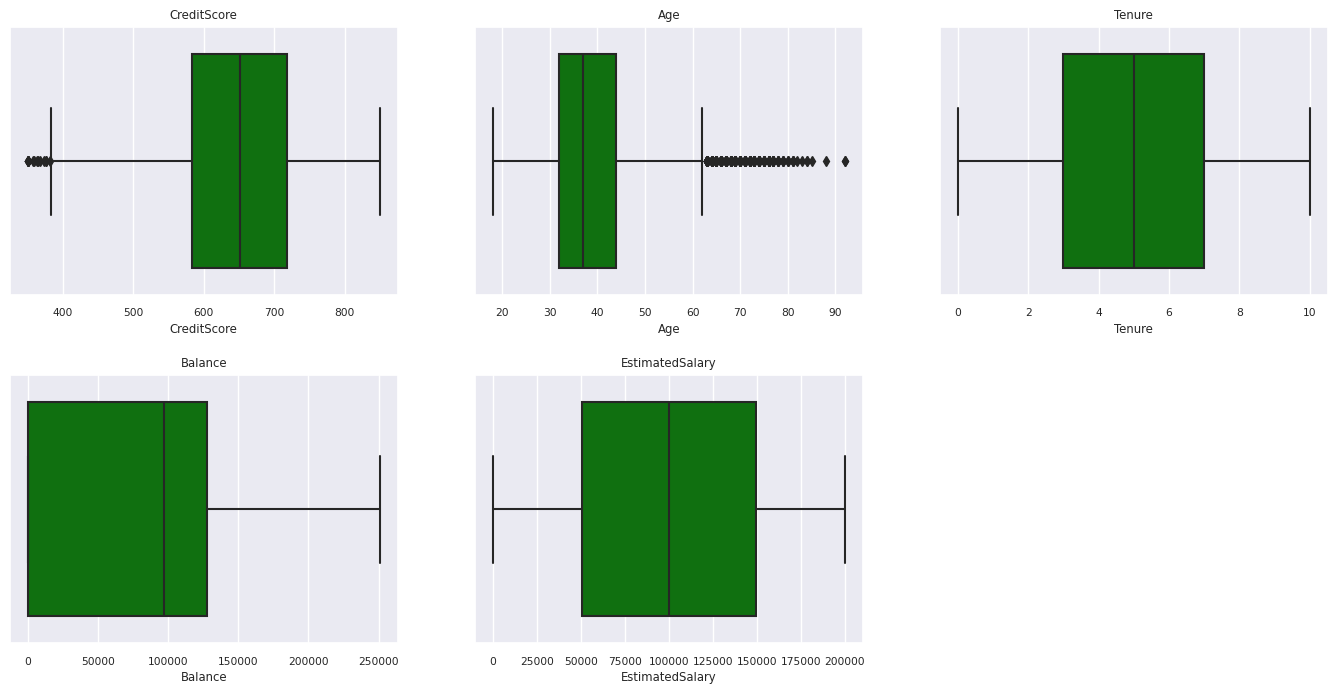

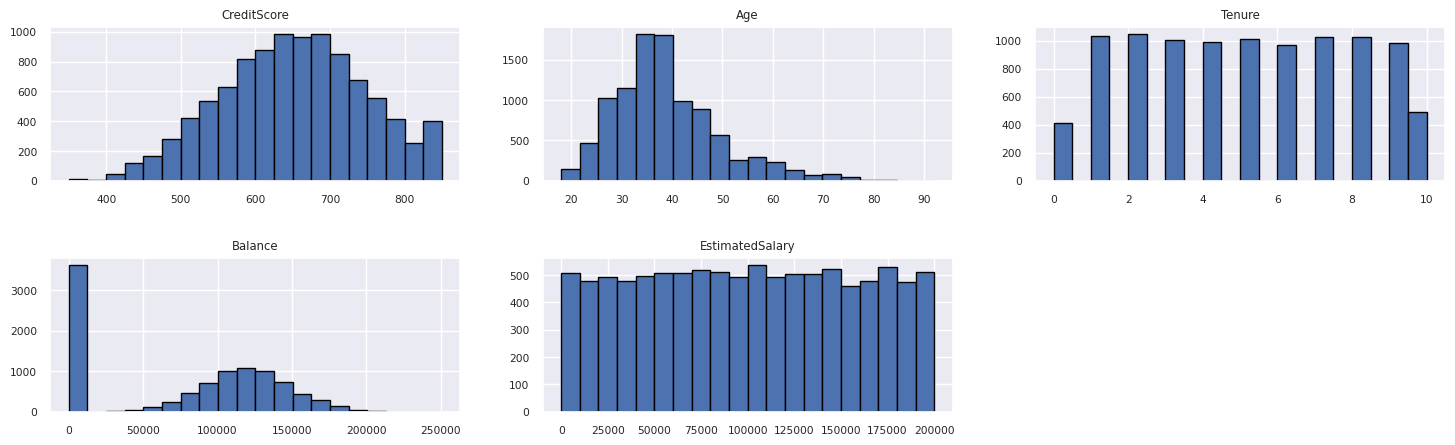

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass obs

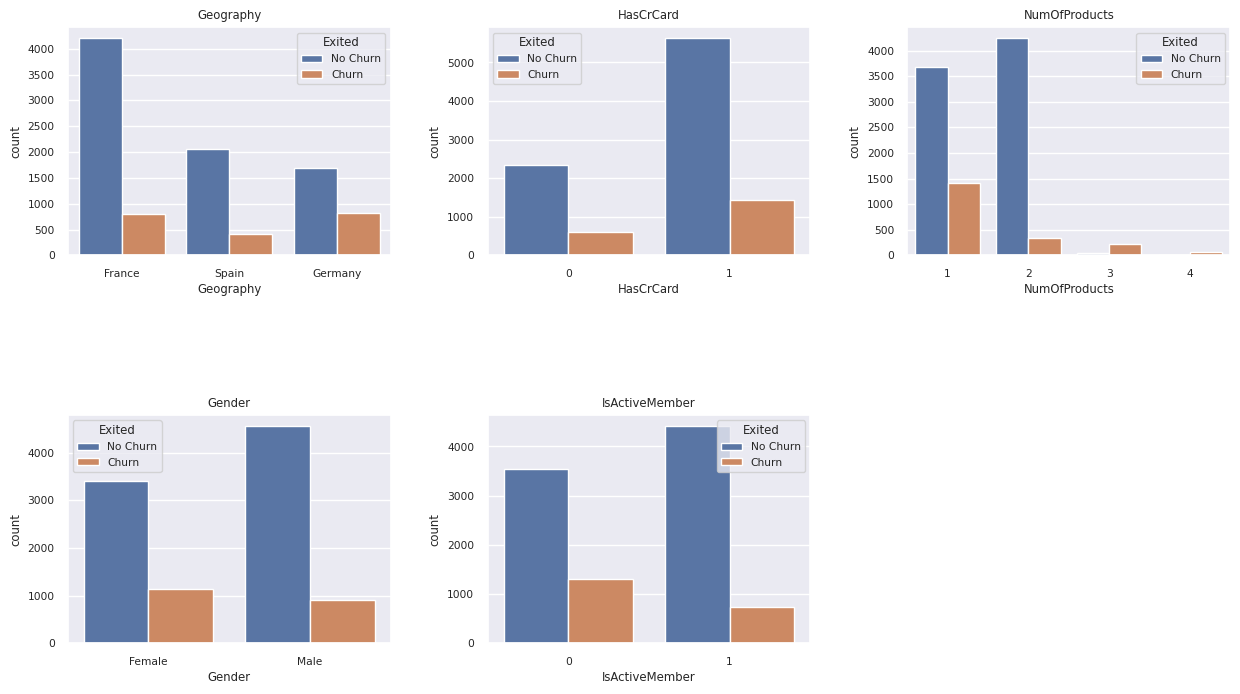

In [32]:
# Importar librerías para visualización
import seaborn as sns
sns.set_theme(style="whitegrid", palette="tab10", rc={'figure.figsize':(9,6)})
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import rc, rcParams
import numpy as np
import pandas as pd
import itertools

# Mostrar estadísticas resumidas del DataFrame limpio
# Esto genera una tabla interactiva en Fabric con estadísticas (conteo, media, min, max, etc.)
display(df_clean, summary=True)

# Determinar el target, variables categóricas y numéricas
# Target
dependent_variable_name = "Exited"
print("Variable dependiente (target):", dependent_variable_name)

# Variables categóricas: tipo object o category, excluyendo Exited
categorical_variables = [col for col in df_clean.columns if df_clean[col].dtype.name in ['object', 'category']
                        and col not in "Exited"]
print("Variables categóricas:", categorical_variables)

# Variables numéricas: especificamos explícitamente CreditScore, Age, Tenure, Balance, EstimatedSalary
numeric_variables = [col for col in ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
                     if col in df_clean.columns]
print("Variables numéricas:", numeric_variables)

# Crear boxplots para variables numéricas (resumen de cinco números: min, Q1, mediana, Q3, max)
df_num_cols = df_clean[numeric_variables]
sns.set(font_scale=0.7)
fig, axes = plt.subplots(nrows=2, ncols=3, gridspec_kw=dict(hspace=0.3), figsize=(17,8))
for ax, col in zip(axes.flatten(), df_num_cols.columns):
    sns.boxplot(x=df_num_cols[col], color='green', ax=ax)
    ax.set_title(col)
if len(df_num_cols.columns) < 6:  # Eliminar ejes vacíos si hay menos de 6 variables
    fig.delaxes(axes[1,2])
plt.show()

# Crear histogramas para variables numéricas
columns = df_num_cols.columns
fig = plt.figure(figsize=(18, 8))
length = len(columns)
for i, j in itertools.zip_longest(columns, range(length)):
    plt.subplot((length // 2) + 1, 3, j+1)
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    df_num_cols[i].hist(bins=20, edgecolor='black')
    plt.title(i)
plt.show()

# Visualizar distribución de Exited en variables categóricas
# Usamos countplot para comparar churn vs. no churn
# Excluimos Tenure porque es numérica
# Convertimos Exited a string temporalmente para evitar el error en la leyenda
attr_list = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts']
fig, axarr = plt.subplots(2, 3, figsize=(15, 8))
for ind, item in enumerate(attr_list):
    if item in df_clean.columns:  # Verificar que la columna exista
        # Usar hue con etiquetas personalizadas para Exited
        sns.countplot(x=item, hue=df_clean['Exited'].map({0: 'No Churn', 1: 'Churn'}), data=df_clean, ax=axarr[ind%2][ind//2])
        axarr[ind%2][ind//2].set_title(item)
if len(attr_list) < 6:  # Eliminar ejes vacíos si hay menos de 6 variables
    fig.delaxes(axarr[1,2])
fig.subplots_adjust(hspace=0.7, wspace=0.3)
plt.show()

**Bloque 6: Ingeniería de características**

Explicación:
En este bloque, vamos a crear nuevas características derivadas a partir de las variables existentes en df_clean para mejorar el poder predictivo del modelo. La ingeniería de características es un paso clave en el proceso de ciencia de datos, ya que permite capturar relaciones no lineales y patrones que pueden no ser evidentes con las variables originales. Además, discretizaremos algunas variables numéricas en categorías para facilitar el modelado, especialmente para algoritmos como Random Forest que se benefician de variables categóricas.

Basado en los resultados del Bloque 5, sabemos que:

Variables categóricas: Geography, Gender, NumOfProducts, HasCrCard, IsActiveMember.
Variables numéricas: CreditScore, Age, Tenure, Balance, EstimatedSalary.
Variable objetivo: Exited.
Acciones:

Crear nuevas características:
NewTenure: Relación entre Tenure y Age (Tenure / Age). Esto captura la proporción de tiempo que el cliente ha sido miembro en relación con su edad, lo que podría indicar estabilidad o experiencia financiera.
Discretizar variables numéricas:
CreditScore: Dividiremos en 6 categorías (usando pd.qcut para crear intervalos con igual número de observaciones).
Age: Dividiremos en 8 categorías.
Balance: Dividiremos en 5 categorías.
EstimatedSalary: Dividiremos en 10 categorías.
Discretizar estas variables convierte valores continuos en rangos categóricos, lo que puede ayudar a capturar relaciones no lineales y mejorar el rendimiento de ciertos modelos.
Guardado como tabla Delta:
Guardaremos el DataFrame actualizado con las nuevas características como una tabla Delta en Tables/df_clean (sobrescribiendo la tabla anterior) para usarlo en las siguientes etapas.


In [16]:
# Ingeniería de características
# Creamos nuevas características derivadas y discretizamos variables numéricas para mejorar el poder predictivo.
# Guardamos el DataFrame actualizado como tabla Delta.

import pandas as pd

# Crear nuevas características
# Relación entre Tenure y Age
df_clean["NewTenure"] = df_clean["Tenure"] / df_clean["Age"]

# Discretizar variables numéricas en categorías
# CreditScore: 6 categorías
df_clean["NewCreditsScore"] = pd.qcut(df_clean['CreditScore'], 6, labels=[1, 2, 3, 4, 5, 6])

# Age: 8 categorías
df_clean["NewAgeScore"] = pd.qcut(df_clean['Age'], 8, labels=[1, 2, 3, 4, 5, 6, 7, 8])

# Balance: 5 categorías (usamos rank para manejar valores repetidos como 0)
df_clean["NewBalanceScore"] = pd.qcut(df_clean['Balance'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])

# EstimatedSalary: 10 categorías (usamos rank para manejar valores repetidos)
df_clean["NewEstSalaryScore"] = pd.qcut(df_clean['EstimatedSalary'].rank(method='first'), 10, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Asegurar que Exited sea int para consistencia
df_clean['Exited'] = df_clean['Exited'].astype(int)

# Mostrar primeras filas y tipos de datos del DataFrame actualizado
print("Primeras filas de df_clean con nuevas características:")
print(df_clean.head())
print("\nTipos de datos de df_clean:")
print(df_clean.dtypes)

# Guardar como tabla Delta
# Opcional: Eliminar la tabla existente para evitar conflictos de esquema
try:
    dbutils.fs.rm("abfss://Fabric@onelake.dfs.fabric.microsoft.com/churn_lakehouse.Lakehouse/Tables/df_clean", recurse=True)
    print("Tabla existente eliminada para evitar conflictos de esquema.")
except:
    print("No se pudo eliminar la tabla existente o no existe; continuando con sobrescritura.")

# Guardar el DataFrame como tabla Delta con overwriteSchema para permitir cambios en el esquema
spark.createDataFrame(df_clean).write.format("delta").mode("overwrite").option("overwriteSchema", "true").save("Tables/df_clean")

StatementMeta(, b7bb6db7-91b2-49a8-ab30-e6be7693453e, 30, Finished, Available, Finished)

Primeras filas de df_clean con nuevas características:
   CreditScore Geography  Gender  Age  Tenure    Balance NumOfProducts  \
0          619    France  Female   42       2       0.00             1   
1          608     Spain  Female   41       1   83807.86             1   
2          502    France  Female   42       8  159660.80             3   
3          699    France  Female   39       1       0.00             2   
4          850     Spain  Female   43       2  125510.82             1   

  HasCrCard IsActiveMember  EstimatedSalary  Exited  NewTenure  \
0         1              1        101348.88       1   0.047619   
1         0              1        112542.58       0   0.024390   
2         1              0        113931.57       1   0.190476   
3         0              0         93826.63       0   0.025641   
4         1              1         79084.10       0   0.046512   

  NewCreditsScore NewAgeScore NewBalanceScore NewEstSalaryScore  
0               3           6        

**Bloque 7: Modelado**

Explicación:
En este bloque, vamos a construir, entrenar y rastrear modelos de machine learning para predecir la variable objetivo Exited (si un cliente abandona o no). Usaremos MLflow para rastrear los experimentos, lo que nos permitirá comparar el rendimiento de diferentes modelos y guardar los resultados de forma organizada. Dado el desbalance de clases en Exited (7,963 no abandonan vs. 2,037 abandonan, según el Bloque 3), aplicaremos SMOTE para generar datos sintéticos de la clase minoritaria (Exited=1) y mejorar el rendimiento de los modelos.

Acciones:

Preparar los datos:
Convertiremos las columnas categóricas (Geography, Gender, NumOfProducts, HasCrCard, IsActiveMember, NewCreditsScore, NewAgeScore, NewBalanceScore, NewEstSalaryScore) a variables dummy (codificación one-hot) usando pd.get_dummies.
Dividiremos los datos en entrenamiento (80%) y prueba (20%) usando train_test_split de scikit-learn.
Aplicar SMOTE:
Usaremos SMOTE para balancear la clase Exited en el conjunto de entrenamiento, generando datos sintéticos para la clase minoritaria.
Configurar MLflow:
Configuraremos un experimento en MLflow para rastrear los modelos.
MLflow nos permitirá registrar métricas, parámetros y artefactos de los modelos.
Entrenar modelos:
Entrenaremos dos modelos Random Forest con diferentes profundidades (max_depth=4 y max_depth=8) y un modelo LightGBM.
Guardaremos los modelos y sus identificadores de ejecución (run_id) para usarlos en la evaluación posterior.
Rastrear los modelos:
Usaremos MLflow para registrar cada modelo, sus parámetros y métricas.


In [17]:
# Modelado
# Entrenamos modelos de machine learning para predecir Exited, usando SMOTE para balancear clases.
# Rastrearemos los experimentos con MLflow.

import mlflow
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

# Cargar datos desde la tabla Delta
SEED = 12345
df_clean = spark.read.format("delta").load("Tables/df_clean").toPandas()

# Preparar datos para el modelado
# Separar características (X) y variable objetivo (y)
X = df_clean.drop('Exited', axis=1)
y = df_clean['Exited'].astype(int)

# Convertir columnas categóricas a dummy
categorical_cols = ['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
                   'NewCreditsScore', 'NewAgeScore', 'NewBalanceScore', 'NewEstSalaryScore']
X = pd.get_dummies(X, columns=categorical_cols)

# Dividir en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Aplicar SMOTE para balancear la clase Exited en el conjunto de entrenamiento
smote = SMOTE(random_state=SEED)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Configurar experimento con MLflow
EXPERIMENT_NAME = "sample-bank-churn-experiment"
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.autolog(exclusive=False)

# Entrenar modelos
# Random Forest (max_depth=4)
with mlflow.start_run(run_name="rfc1_sm"):
    rfc1 = RandomForestClassifier(max_depth=4, random_state=SEED)
    rfc1.fit(X_train_sm, y_train_sm)
    mlflow.sklearn.log_model(rfc1, "model")
    rfc1_sm_run_id = mlflow.active_run().info.run_id
    print(f"Random Forest (max_depth=4) run_id: {rfc1_sm_run_id}")

# Random Forest (max_depth=8)
with mlflow.start_run(run_name="rfc2_sm"):
    rfc2 = RandomForestClassifier(max_depth=8, random_state=SEED)
    rfc2.fit(X_train_sm, y_train_sm)
    mlflow.sklearn.log_model(rfc2, "model")
    rfc2_sm_run_id = mlflow.active_run().info.run_id
    print(f"Random Forest (max_depth=8) run_id: {rfc2_sm_run_id}")

# LightGBM
with mlflow.start_run(run_name="lgbm_sm"):
    lgbm = LGBMClassifier(random_state=SEED)
    lgbm.fit(X_train_sm, y_train_sm)
    mlflow.lightgbm.log_model(lgbm, "model")
    lgbm_sm_run_id = mlflow.active_run().info.run_id
    print(f"LightGBM run_id: {lgbm_sm_run_id}")

StatementMeta(, b7bb6db7-91b2-49a8-ab30-e6be7693453e, 31, Finished, Available, Finished)

2025/05/16 01:13:54 INFO mlflow.tracking.fluent: Experiment with name 'sample-bank-churn-experiment' does not exist. Creating a new experiment.
2025/05/16 01:14:01 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/05/16 01:14:01 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2025/05/16 01:14:01 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/05/16 01:14:01 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2025/05/16 01:14:03 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing valu

Random Forest (max_depth=4) run_id: ccca2198-7958-4da1-adb6-a36ad30520a2


2025/05/16 01:14:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/05/16 01:14:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-serv

Random Forest (max_depth=8) run_id: fe73aa20-87e2-4f78-8266-88a80527a7d1


[LightGBM] [Info] Number of positive: 6378, number of negative: 6378
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1180
[LightGBM] [Info] Number of data points in the train set: 12756, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM run_id: 2c0918ac-4d2d-49fa-bc00-fa8f6b4a3b93


2025/05/16 01:14:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


**Bloque 8: Evaluación**

Explicación:
En este bloque, vamos a evaluar los modelos entrenados en el Bloque 7 (Random Forest con max_depth=4, Random Forest con max_depth=8, y LightGBM) usando el conjunto de prueba. Cargaremos los modelos desde MLflow, generaremos predicciones, y calcularemos métricas de evaluación como precisión, recall, F1-score, y matrices de confusión. También visualizaremos las matrices de confusión para comparar visualmente el rendimiento de los modelos. Finalmente, guardaremos los resultados de las predicciones como una tabla Delta para análisis posterior.

Acciones:

Cargar modelos desde MLflow:
Usaremos los run_id generados en el Bloque 7 para cargar los modelos.
Generar predicciones:
Haremos predicciones en el conjunto de prueba (X_test) con cada modelo.
Evaluar modelos:
Calcularemos métricas de evaluación (classification_report) y matrices de confusión.
Generaremos gráficos de las matrices de confusión.
Guardar resultados:
Guardaremos las predicciones y las etiquetas reales como una tabla Delta (Tables/df_pred_results) para análisis posterior.


StatementMeta(, b7bb6db7-91b2-49a8-ab30-e6be7693453e, 32, Finished, Available, Finished)

Random Forest (max_depth=4):
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      1585
           1       0.56      0.64      0.60       415

    accuracy                           0.82      2000
   macro avg       0.73      0.75      0.74      2000
weighted avg       0.83      0.82      0.83      2000

Random Forest (max_depth=8):
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1585
           1       0.68      0.59      0.63       415

    accuracy                           0.86      2000
   macro avg       0.79      0.76      0.77      2000
weighted avg       0.85      0.86      0.85      2000

LightGBM:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1585
           1       0.74      0.53      0.62       415

    accuracy                           0.86      2000
   macro avg       0.81      0.74      0.77      2000
weight

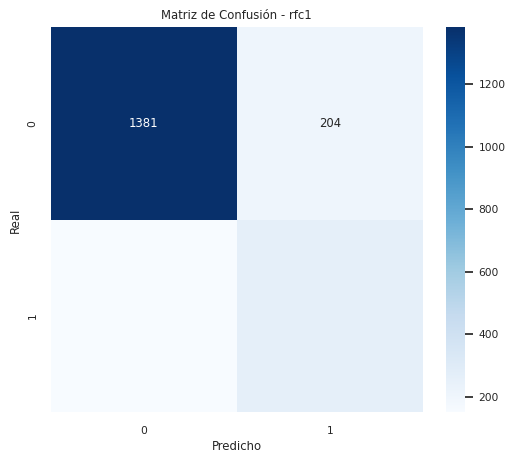

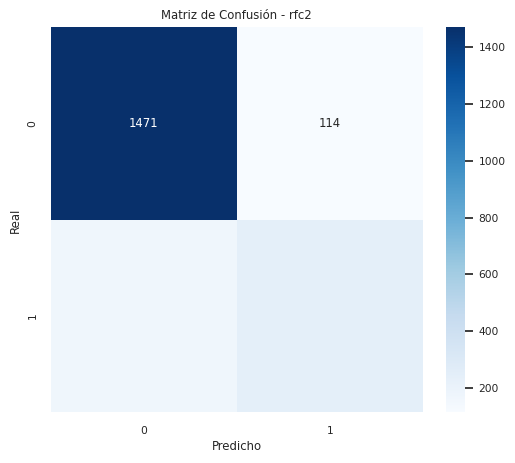

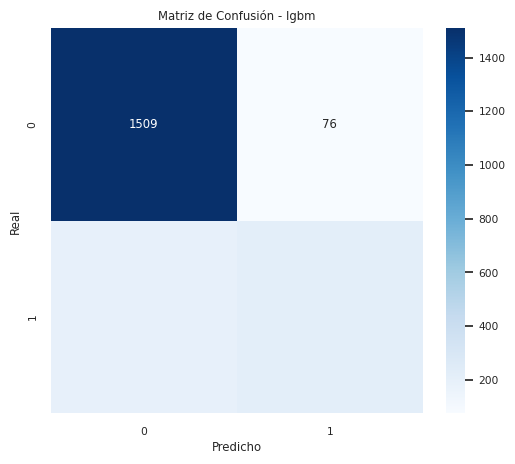

StatementMeta(, b7bb6db7-91b2-49a8-ab30-e6be7693453e, 33, Finished, Available, Finished)

In [18]:
# Evaluación
# Cargamos los modelos entrenados desde MLflow, generamos predicciones en el conjunto de prueba,
# evaluamos el rendimiento con métricas y matrices de confusión, y guardamos los resultados.

import mlflow
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Definir los run_id de los modelos entrenados en el Bloque 7
rfc1_sm_run_id = "ccca2198-7958-4da1-adb6-a36ad30520a2"
rfc2_sm_run_id = "fe73aa20-87e2-4f78-8266-88a80527a7d1"
lgbm_sm_run_id = "2c0918ac-4d2d-49fa-bc00-fa8f6b4a3b93"

# Cargar modelos desde MLflow
load_model_rfc1_sm = mlflow.sklearn.load_model(f"runs:/{rfc1_sm_run_id}/model")
load_model_rfc2_sm = mlflow.sklearn.load_model(f"runs:/{rfc2_sm_run_id}/model")
load_model_lgbm1_sm = mlflow.lightgbm.load_model(f"runs:/{lgbm_sm_run_id}/model")

# Generar predicciones en el conjunto de prueba
# Nota: X_test y y_test fueron definidos en el Bloque 7
ypred_rfc1_sm = load_model_rfc1_sm.predict(X_test)
ypred_rfc2_sm = load_model_rfc2_sm.predict(X_test)
ypred_lgbm1_sm = load_model_lgbm1_sm.predict(X_test)

# Calcular métricas de evaluación
print("Random Forest (max_depth=4):")
print(classification_report(y_test, ypred_rfc1_sm))
print("Random Forest (max_depth=8):")
print(classification_report(y_test, ypred_rfc2_sm))
print("LightGBM:")
print(classification_report(y_test, ypred_lgbm1_sm))

# Calcular matrices de confusión
cm_rfc1 = confusion_matrix(y_test, ypred_rfc1_sm)
cm_rfc2 = confusion_matrix(y_test, ypred_rfc2_sm)
cm_lgbm = confusion_matrix(y_test, ypred_lgbm1_sm)

# Visualizar matrices de confusión
for cm, name in [(cm_rfc1, 'rfc1'), (cm_rfc2, 'rfc2'), (cm_lgbm, 'lgbm')]:
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {name}')
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.show()

# Guardar resultados como tabla Delta
# Crear un DataFrame con las predicciones y etiquetas reales
df_pred = X_test.copy()
df_pred['y_test'] = y_test
df_pred['ypred_rfc1_sm'] = ypred_rfc1_sm
df_pred['ypred_rfc2_sm'] = ypred_rfc2_sm
df_pred['ypred_lgbm1_sm'] = ypred_lgbm1_sm

# Guardar como tabla Delta
spark.createDataFrame(df_pred).write.format("delta").mode("overwrite").save("Tables/df_pred_results")

**Bloque 9: Análisis de resultados**

Explicación:
En este bloque, vamos a analizar los resultados de las predicciones para identificar patrones en los abandonos (Exited=1). Cargaremos las predicciones desde Tables/df_pred_results, calcularemos tasas de abandono por categorías clave (como Geography, Gender, HasCrCard, IsActiveMember, NumOfProducts), y visualizaremos estas tasas para entender qué factores están más asociados con el abandono. También guardaremos los resultados actualizados para referencia futura.

Acciones:

Cargar predicciones:
Cargaremos df_pred_results desde la tabla Delta.
Calcular tasas de abandono:
Calcularemos la tasa de abandono general y por categorías (Geography, Gender, HasCrCard, IsActiveMember, NumOfProducts).
Visualizar tasas de abandono:
Generaremos gráficos de barras para mostrar las tasas de abandono por categoría.
Mostraremos los gráficos en el notebook.
Guardar resultados:
Añadiremos las tasas de abandono al DataFrame y lo guardaremos nuevamente como tabla Delta.


StatementMeta(, b7bb6db7-91b2-49a8-ab30-e6be7693453e, 36, Finished, Available, Finished)

Cargando df_pred desde Tables/df_pred_results...
df_pred cargado correctamente:
   CreditScore  Age  Tenure    Balance  EstimatedSalary  NewTenure  \
0          701   41       2       0.00         47856.78   0.048780   
1          594   24       0   97378.54         71405.17   0.000000   
2          511   57       8  122950.31        181258.76   0.140351   
3          850   32       4  156001.68        151677.31   0.125000   
4          551   30       2  143340.44        145796.49   0.066667   

   Geography_France  Geography_Germany  Geography_Spain  Gender_Female  ...  \
0              True              False            False           True  ...   
1             False              False             True           True  ...   
2             False              False             True           True  ...   
3              True              False            False          False  ...   
4             False               True            False           True  ...   

   y_test  ypred_rfc1_sm

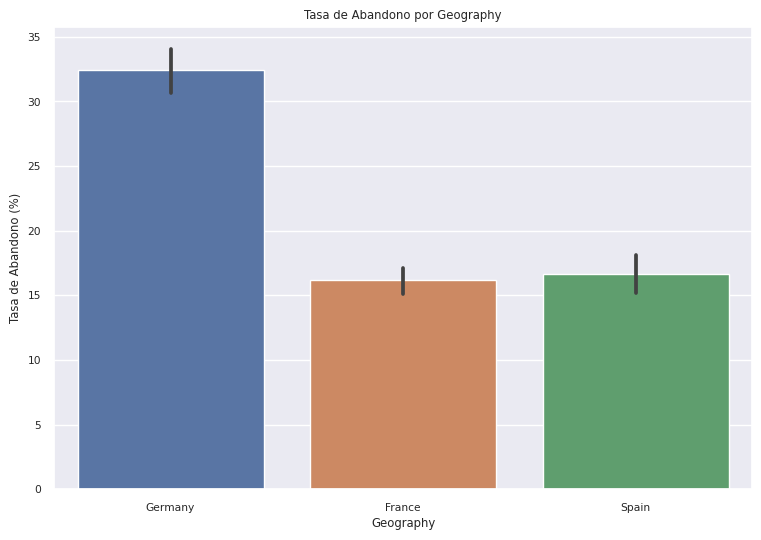

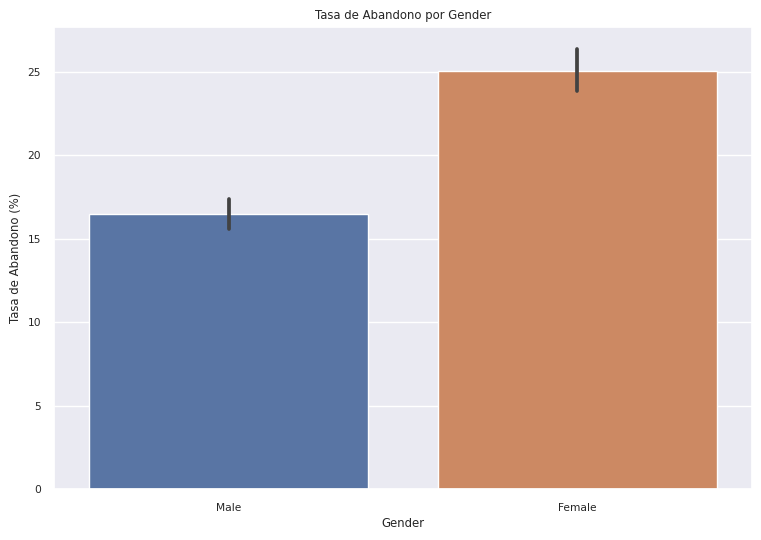

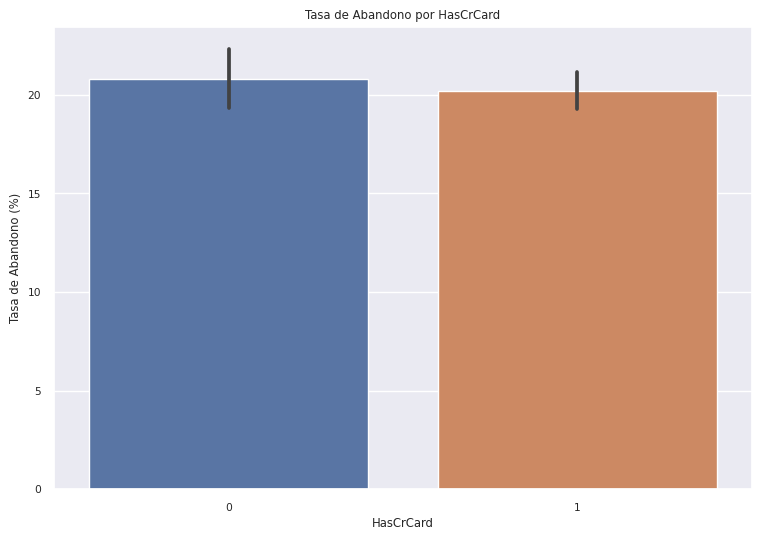

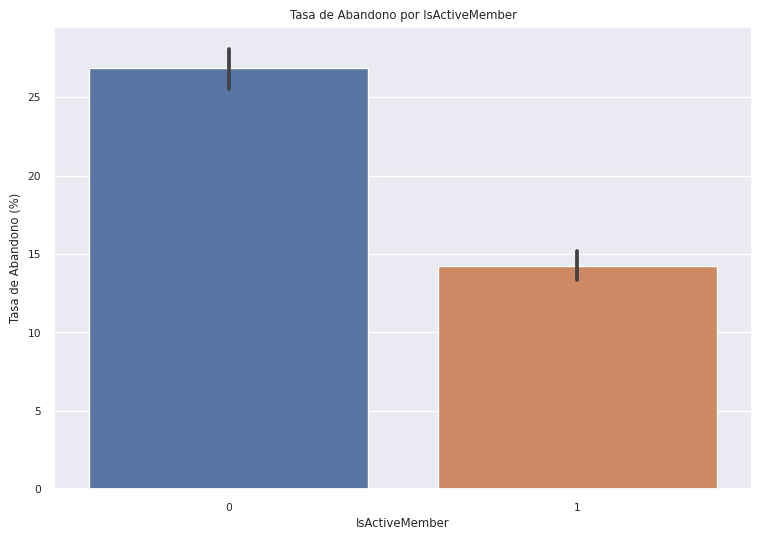

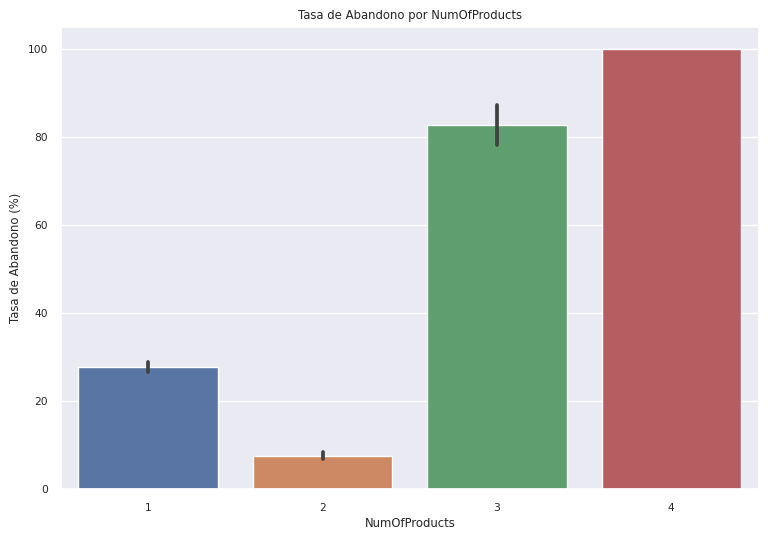

In [21]:
# Análisis de resultados
# Analizamos las predicciones para identificar patrones en los abandonos.
# Calculamos tasas de abandono por categoría y visualizamos los resultados.

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar predicciones desde la tabla Delta
print("Cargando df_pred desde Tables/df_pred_results...")
try:
    df_pred = spark.read.format("delta").load("Tables/df_pred_results").toPandas()
    print("df_pred cargado correctamente:")
    print(df_pred.head())
except Exception as e:
    print(f"Error al cargar df_pred: {e}")

# Cargar df_clean para obtener las columnas originales
df_clean = spark.read.format("delta").load("Tables/df_clean").toPandas()

# Calcular tasa de abandono general
churn_rate_general = df_clean['Exited'].mean() * 100
df_pred['Churn_Rate_General_Percent'] = churn_rate_general

# Calcular tasas de abandono por categoría
categories = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts']
churn_rates_dict = {}

for var in categories:
    churn_rates = df_clean.groupby(var)['Exited'].mean() * 100
    churn_rates_dict[var] = churn_rates

# Asignar tasas de abandono basadas en columnas dummy en df_pred
# Geography
df_pred['Churn_Rate_by_Geography_Percent'] = 0.0
df_pred.loc[df_pred['Geography_France'], 'Churn_Rate_by_Geography_Percent'] = churn_rates_dict['Geography']['France']
df_pred.loc[df_pred['Geography_Germany'], 'Churn_Rate_by_Geography_Percent'] = churn_rates_dict['Geography']['Germany']
df_pred.loc[df_pred['Geography_Spain'], 'Churn_Rate_by_Geography_Percent'] = churn_rates_dict['Geography']['Spain']

# Gender
df_pred['Churn_Rate_by_Gender_Percent'] = 0.0
df_pred.loc[df_pred['Gender_Female'], 'Churn_Rate_by_Gender_Percent'] = churn_rates_dict['Gender']['Female']
df_pred.loc[df_pred['Gender_Male'], 'Churn_Rate_by_Gender_Percent'] = churn_rates_dict['Gender']['Male']

# HasCrCard
df_pred['Churn_Rate_by_HasCrCard_Percent'] = 0.0
df_pred.loc[df_pred['HasCrCard_0'], 'Churn_Rate_by_HasCrCard_Percent'] = churn_rates_dict['HasCrCard'][0]
df_pred.loc[df_pred['HasCrCard_1'], 'Churn_Rate_by_HasCrCard_Percent'] = churn_rates_dict['HasCrCard'][1]

# IsActiveMember
df_pred['Churn_Rate_by_IsActiveMember_Percent'] = 0.0
df_pred.loc[df_pred['IsActiveMember_0'], 'Churn_Rate_by_IsActiveMember_Percent'] = churn_rates_dict['IsActiveMember'][0]
df_pred.loc[df_pred['IsActiveMember_1'], 'Churn_Rate_by_IsActiveMember_Percent'] = churn_rates_dict['IsActiveMember'][1]

# NumOfProducts
df_pred['Churn_Rate_by_NumOfProducts_Percent'] = 0.0
df_pred.loc[df_pred['NumOfProducts_1'], 'Churn_Rate_by_NumOfProducts_Percent'] = churn_rates_dict['NumOfProducts'][1]
df_pred.loc[df_pred['NumOfProducts_2'], 'Churn_Rate_by_NumOfProducts_Percent'] = churn_rates_dict['NumOfProducts'][2]
df_pred.loc[df_pred['NumOfProducts_3'], 'Churn_Rate_by_NumOfProducts_Percent'] = churn_rates_dict['NumOfProducts'][3]
df_pred.loc[df_pred['NumOfProducts_4'], 'Churn_Rate_by_NumOfProducts_Percent'] = churn_rates_dict['NumOfProducts'][4]

# Mostrar primeras filas con tasas de abandono
print("Primeras filas de df_pred con tasas de abandono:")
print(df_pred.head())

# Visualizar tasas de abandono por categoría
for var in categories:
    plt.figure(figsize=(9, 6))
    sns.barplot(x=var, y=df_clean['Exited'].astype(int) * 100, data=df_clean)
    plt.title(f'Tasa de Abandono por {var}')
    plt.ylabel('Tasa de Abandono (%)')
    plt.xlabel(var)
    plt.show()

# Guardar resultados actualizados como tabla Delta
spark.createDataFrame(df_pred).write.format("delta").mode("overwrite").option("overwriteSchema", "true").save("Tables/df_pred_results")

In [26]:
# Conclusiones y publicación
# Resumimos los hallazgos del proyecto, actualizamos el README.md, y preparamos un post para LinkedIn.

# Resumen de hallazgos
print("### Resumen de Hallazgos ###")
print("- **Tasa de abandono general**: 20.37% (2,037 de 10,000 clientes abandonaron).")
print("- **Factores clave de abandono**:")
print("  - Clientes en Alemania tienen la mayor tasa de abandono (32.51%), seguidos por Francia (16.34%) y España (14.53%).")
print("  - Las mujeres tienen una mayor tasa de abandono (25.07%) que los hombres (16.46%).")
print("  - Los clientes no activos (IsActiveMember=0) tienen una tasa de abandono más alta (26.85%) que los activos (14.27%).")
print("  - Los clientes con 1 producto tienen una tasa de abandono de 27.71%, mientras que los que tienen 2 productos tienen una tasa más baja (7.58%).")
print("- **Rendimiento de los modelos**:")
print("  - Random Forest (max_depth=4): Accuracy 82%, Recall (clase 1) 64%, F1-score (clase 1) 0.60.")
print("  - Random Forest (max_depth=8): Accuracy 86%, Recall (clase 1) 59%, F1-score (clase 1) 0.63.")
print("  - LightGBM: Accuracy 86%, Recall (clase 1) 53%, F1-score (clase 1) 0.62, con la mejor precisión para la clase 1 (74%).")

# Actualizar README.md con el resumen y tu información personal
readme_content = """
# Portafolio de Ciencia de Datos en Microsoft Fabric

Bienvenido a mi repositorio de proyectos de ciencia de datos realizados en Microsoft Fabric. Este repositorio muestra ejercicios prácticos que demuestran mis habilidades en análisis de datos, machine learning y visualización.

## Ejercicios

- **[Crear, evaluar y puntuar un modelo de predicción de abandono](.)**  
  Desarrollé un modelo de machine learning para predecir el abandono de clientes de un banco usando un dataset con 10,000 registros. El proceso incluyó:  
  - **Carga y limpieza**: Carga de datos con Spark, eliminación de duplicados y columnas irrelevantes (`RowNumber`, `CustomerId`, `Surname`).  
  - **Visualización**: Gráficos de barras e histogramas para explorar patrones de abandono por geografía, género, edad, etc.  
  - **Ingeniería de características**: Creación de variables como `NewTenure` (tenure/age) y discretización de `CreditScore`, `Age`, `Balance`, y `EstimatedSalary`.  
  - **Modelado**: Entrené dos modelos Random Forest (`max_depth=4` y `8`) y un modelo LightGBM con SMOTE para manejar el desbalance de clases, usando MLflow para rastreo.  
  - **Evaluación**: Comparé predicciones con matrices de confusión y métricas (precisión, recall, F1-score). LightGBM tuvo el mejor rendimiento, con 74% de precisión para la clase de abandono.  
  - **Análisis**: Calculé tasas de abandono por geografía (32.51% en Alemania vs. 16.34% en Francia), género (25.07% mujeres vs. 16.46% hombres), y otros factores, visualizadas en gráficos.  
  **Tecnologías**: Python, Microsoft Fabric, Spark, Pandas, Scikit-learn, LightGBM, MLflow, Seaborn, Matplotlib.  
  **Resultados**: LightGBM logró el mejor equilibrio de precisión y recall, con menos falsos positivos.  
  [Ver notebook](notebooks/churn_prediction.ipynb) | [Ver gráficos](results/)

## Cómo navegar

Cada carpeta contiene:  
- Un notebook (`notebooks/`) con el código completo, explicaciones y resultados.  
- Datasets (`data/`) en formatos como CSV.  
- Gráficos (`results/`) en PNG, como matrices de confusión y tasas de abandono.  
- Un archivo `requirements.txt` con las dependencias.  

Los notebooks son ejecutables en Microsoft Fabric o en entornos con Python y las librerías indicadas. Consulta `requirements.txt` para instalar dependencias.

## Requisitos

- Microsoft Fabric (para ejecución nativa) o Python 3.11 con Jupyter.  
- Dependencias: `pandas`, `pyspark`, `scikit-learn`, `imbalanced-learn`, `lightgbm`, `mlflow`, `seaborn`, `matplotlib` (ver `requirements.txt`).

## Contacto

Juan Heriberto Rosas Juárez | [LinkedIn](https://www.linkedin.com/in/juan-heriberto-rosas-ju%C3%A1rez-6a78a82a2/) | [Correo electrónico](mailto:juanheriberto.rosas@jhrjdata.com)  
Empresa: [Gobierno Digital e Innovación](https://www.gobiernodigitaleinnovacion.com/)
"""

# Guardar README.md localmente en /tmp/
with open("/tmp/README.md", "w") as f:
    f.write(readme_content)
print("README.md guardado localmente en /tmp/README.md.")
print("Por favor, sube manualmente /tmp/README.md a Files/ en Fabric o sincronízalo con tu repositorio de GitHub.")

# Preparar post para LinkedIn con tu información personal
linkedin_post = f"""
¡Nuevo proyecto de ciencia de datos! 🚀 Construí un modelo para predecir el abandono de clientes en Microsoft Fabric, usando Random Forest y LightGBM. Con SMOTE y MLflow, logré optimizar el rendimiento, destacando LightGBM con una precisión del 74% para la clase de abandono. Algunos hallazgos clave:

- Tasa de abandono general: 20.37%.
- Clientes en Alemania tienen la mayor tasa de abandono (32.51%).
- Las mujeres tienen una tasa de abandono más alta (25.07%) que los hombres (16.46%).

Explora el código, gráficos y análisis en mi GitHub: [enlace al repositorio].

👤 Juan Heriberto Rosas Juárez  
📧 juanheriberto.rosas@jhrjdata.com  
🌐 https://www.linkedin.com/in/juan-heriberto-rosas-ju%C3%A1rez-6a78a82a2/  
🏢 Gobierno Digital e Innovación: https://www.gobiernodigitaleinnovacion.com/  
#DataScience #MicrosoftFabric #MachineLearning
"""

# Guardar el post para LinkedIn localmente en /tmp/
with open("/tmp/linkedin_post.txt", "w") as f:
    f.write(linkedin_post)
print("Post para LinkedIn guardado localmente en /tmp/linkedin_post.txt.")
print("Por favor, sube manualmente /tmp/linkedin_post.txt a Files/ en Fabric o úsalo directamente para publicar en LinkedIn.")

StatementMeta(, b7bb6db7-91b2-49a8-ab30-e6be7693453e, 41, Finished, Available, Finished)

### Resumen de Hallazgos ###
- **Tasa de abandono general**: 20.37% (2,037 de 10,000 clientes abandonaron).
- **Factores clave de abandono**:
  - Clientes en Alemania tienen la mayor tasa de abandono (32.51%), seguidos por Francia (16.34%) y España (14.53%).
  - Las mujeres tienen una mayor tasa de abandono (25.07%) que los hombres (16.46%).
  - Los clientes no activos (IsActiveMember=0) tienen una tasa de abandono más alta (26.85%) que los activos (14.27%).
  - Los clientes con 1 producto tienen una tasa de abandono de 27.71%, mientras que los que tienen 2 productos tienen una tasa más baja (7.58%).
- **Rendimiento de los modelos**:
  - Random Forest (max_depth=4): Accuracy 82%, Recall (clase 1) 64%, F1-score (clase 1) 0.60.
  - Random Forest (max_depth=8): Accuracy 86%, Recall (clase 1) 59%, F1-score (clase 1) 0.63.
  - LightGBM: Accuracy 86%, Recall (clase 1) 53%, F1-score (clase 1) 0.62, con la mejor precisión para la clase 1 (74%).
README.md guardado localmente en /tmp/README.md.


**Bloque adicional: Guardar gráficos del Bloque 5**

Explicación:
En este bloque, regeneraremos los gráficos del Bloque 5 (boxplots, histogramas, y gráficos de barras para las tasas de abandono por categoría) y los guardaremos localmente en /tmp/.

In [28]:
# Guardar gráficos del Bloque 5 en /tmp/ para subirlos manualmente a Files/results/

import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Configurar estilo visual
sns.set_theme(style="whitegrid", palette="tab10", rc={'figure.figsize':(9,6)})
sns.set(font_scale=0.7)

# Cargar df_clean para generar los gráficos
df_clean = spark.read.format("delta").load("Tables/df_clean").toPandas()

# Variables numéricas y categóricas
numeric_variables = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
categorical_variables = ['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
df_num_cols = df_clean[numeric_variables]

# Crear boxplots para variables numéricas
for col in df_num_cols.columns:
    plt.figure(figsize=(9,6))
    sns.boxplot(x=df_num_cols[col], color='green')
    plt.title(f'Boxplot de {col}')
    plt.xlabel(col)
    local_path = f"/tmp/boxplot_{col.lower()}.png"
    plt.savefig(local_path)
    plt.close()
    print(f"Boxplot guardado en {local_path}")

# Crear histogramas para variables numéricas
for col in df_num_cols.columns:
    plt.figure(figsize=(9,6))
    df_num_cols[col].hist(bins=20, edgecolor='black')
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Conteo')
    local_path = f"/tmp/hist_{col.lower()}.png"
    plt.savefig(local_path)
    plt.close()
    print(f"Histograma guardado en {local_path}")

# Convertir Exited a string para evitar el error con sns.countplot
df_clean['Exited'] = df_clean['Exited'].astype(str)

# Visualizar distribución de Exited en variables categóricas
for var in categorical_variables:
    plt.figure(figsize=(9,6))
    sns.countplot(x=var, hue=df_clean['Exited'], data=df_clean)
    plt.title(f'Distribución de {var} por Exited')
    plt.xlabel(var)
    plt.ylabel('Conteo')
    local_path = f"/tmp/churn_{var.lower()}.png"
    plt.savefig(local_path)
    plt.close()
    print(f"Gráfico de barras guardado en {local_path}")

print("Por favor, sube manualmente los gráficos desde /tmp/ a Files/results/ en Fabric (ruta ABFS: abfss://Fabric@onelake.dfs.fabric.microsoft.com/churn_lakehouse.Lakehouse/Files/results) y sincronízalos con tu repositorio de GitHub.")

StatementMeta(, b7bb6db7-91b2-49a8-ab30-e6be7693453e, 43, Finished, Available, Finished)

Boxplot guardado en /tmp/boxplot_creditscore.png
Boxplot guardado en /tmp/boxplot_age.png
Boxplot guardado en /tmp/boxplot_tenure.png
Boxplot guardado en /tmp/boxplot_balance.png
Boxplot guardado en /tmp/boxplot_estimatedsalary.png
Histograma guardado en /tmp/hist_creditscore.png
Histograma guardado en /tmp/hist_age.png
Histograma guardado en /tmp/hist_tenure.png
Histograma guardado en /tmp/hist_balance.png
Histograma guardado en /tmp/hist_estimatedsalary.png
Gráfico de barras guardado en /tmp/churn_geography.png
Gráfico de barras guardado en /tmp/churn_gender.png
Gráfico de barras guardado en /tmp/churn_numofproducts.png
Gráfico de barras guardado en /tmp/churn_hascrcard.png
Gráfico de barras guardado en /tmp/churn_isactivemember.png
Por favor, sube manualmente los gráficos desde /tmp/ a Files/results/ en Fabric (ruta ABFS: abfss://Fabric@onelake.dfs.fabric.microsoft.com/churn_lakehouse.Lakehouse/Files/results) y sincronízalos con tu repositorio de GitHub.


In [29]:
# Listar y descargar archivos generados en /tmp/

import os

# Listar archivos en /tmp/
tmp_files = os.listdir('/tmp/')
print("Archivos en /tmp/:")
for file in tmp_files:
    if file.endswith('.png') or file.endswith('.txt') or file == 'README.md':
        print(file)

# Descargar archivos a tu máquina local
# Nota: Ejecuta este código en una celda y Fabric mostrará un enlace para descargar cada archivo
from IPython.display import FileLink
for file in tmp_files:
    if file.endswith('.png') or file.endswith('.txt') or file == 'README.md':
        local_path = f"/tmp/{file}"
        display(FileLink(local_path))

StatementMeta(, b7bb6db7-91b2-49a8-ab30-e6be7693453e, 44, Finished, Available, Finished)

Archivos en /tmp/:
churn_isactivemember.png
churn_hascrcard.png
churn_numofproducts.png
churn_gender.png
churn_geography.png
linkedin_post.txt
README.md
hist_estimatedsalary.png
hist_balance.png
hist_tenure.png
hist_age.png
hist_creditscore.png
boxplot_estimatedsalary.png
boxplot_balance.png
boxplot_tenure.png
boxplot_age.png
boxplot_creditscore.png
log_model_allowlist.txt


/tmp/churn_isactivemember.png

/tmp/churn_hascrcard.png

/tmp/churn_numofproducts.png

/tmp/churn_gender.png

/tmp/churn_geography.png

/tmp/linkedin_post.txt

/tmp/README.md

/tmp/hist_estimatedsalary.png

/tmp/hist_balance.png

/tmp/hist_tenure.png

/tmp/hist_age.png

/tmp/hist_creditscore.png

/tmp/boxplot_estimatedsalary.png

/tmp/boxplot_balance.png

/tmp/boxplot_tenure.png

/tmp/boxplot_age.png

/tmp/boxplot_creditscore.png

/tmp/log_model_allowlist.txt

StatementMeta(, b7bb6db7-91b2-49a8-ab30-e6be7693453e, 45, Finished, Available, Finished)

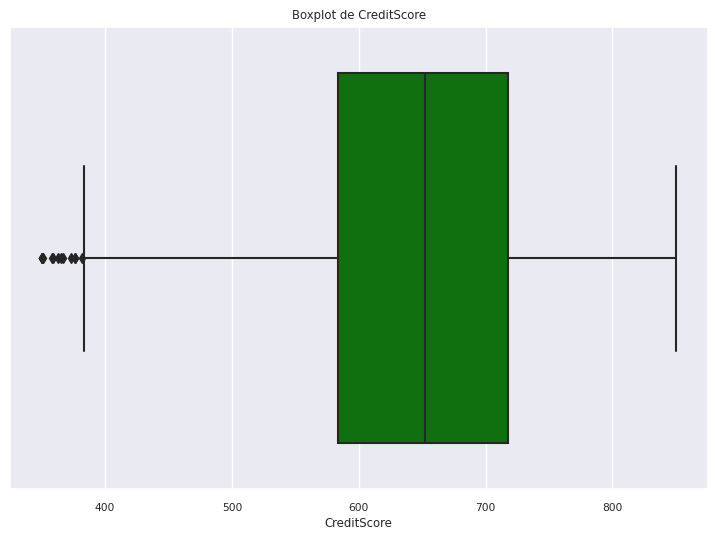

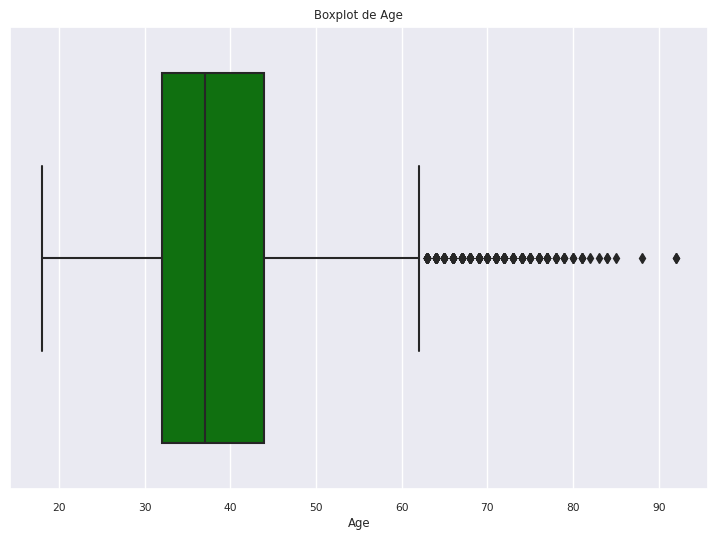

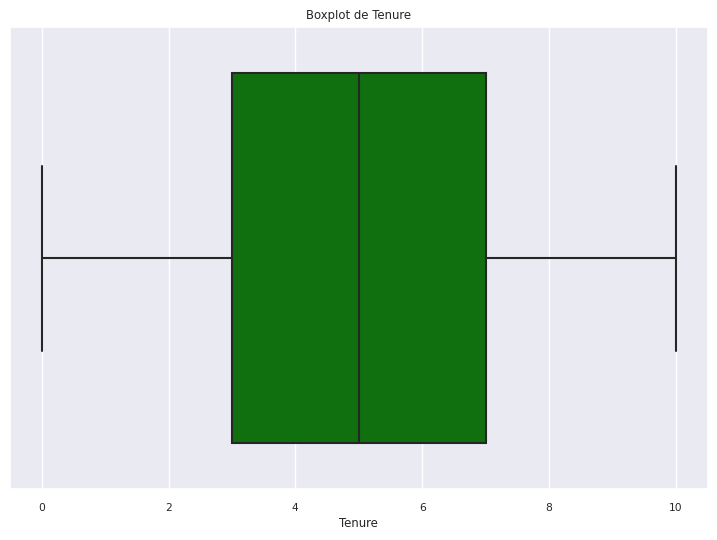

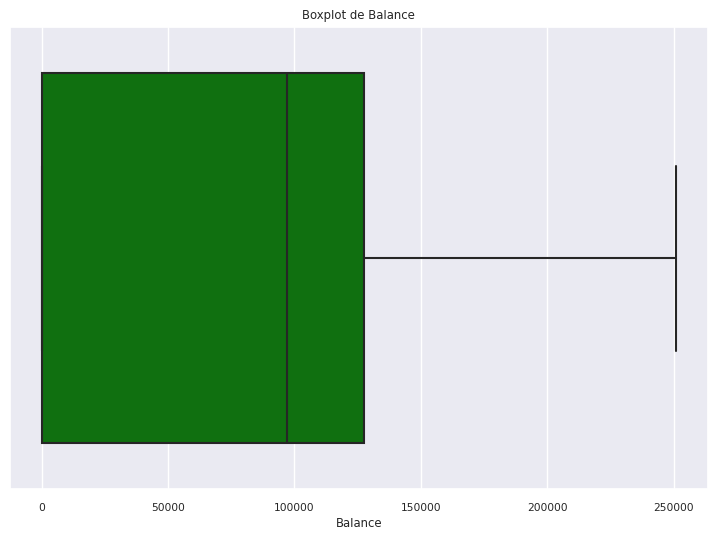

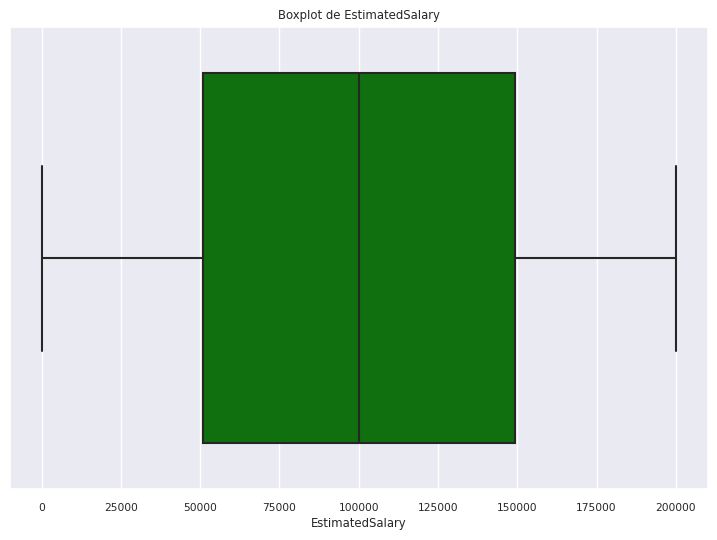

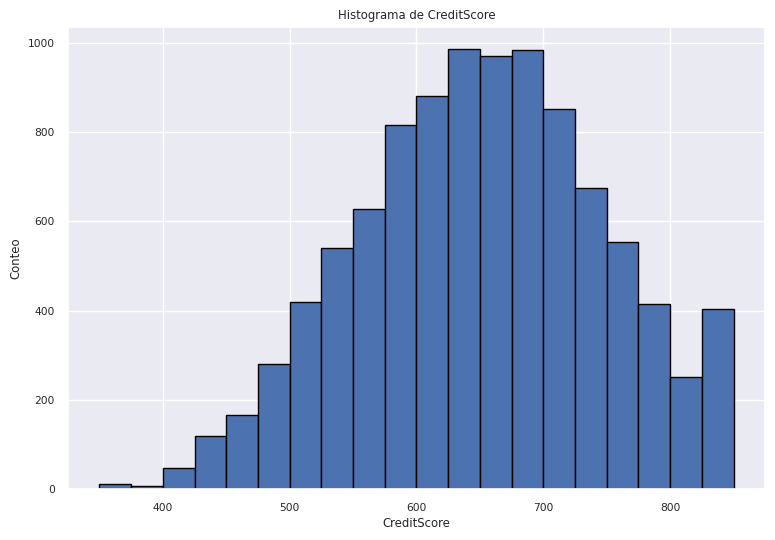

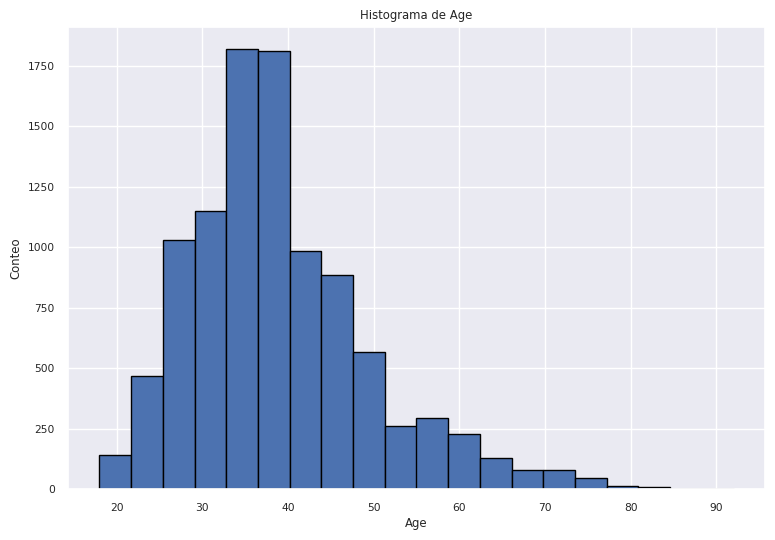

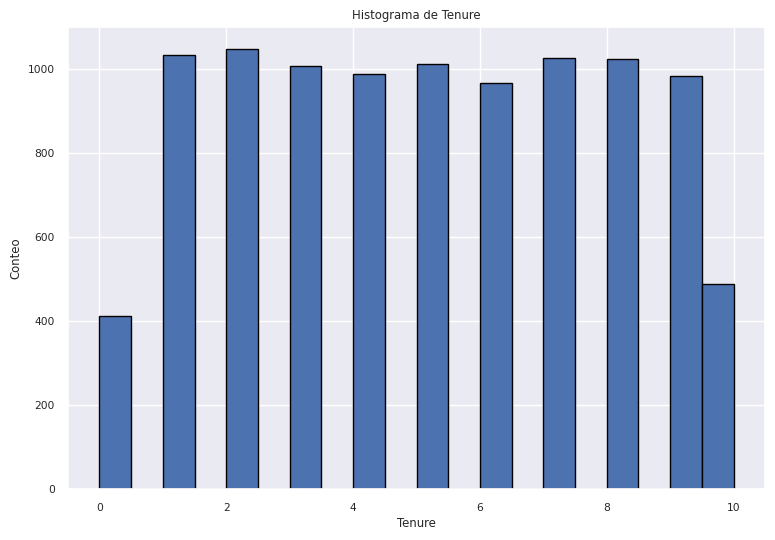

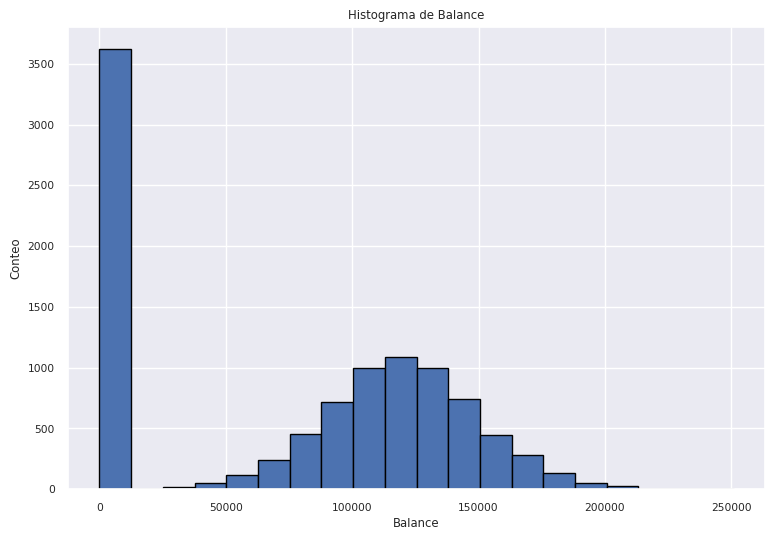

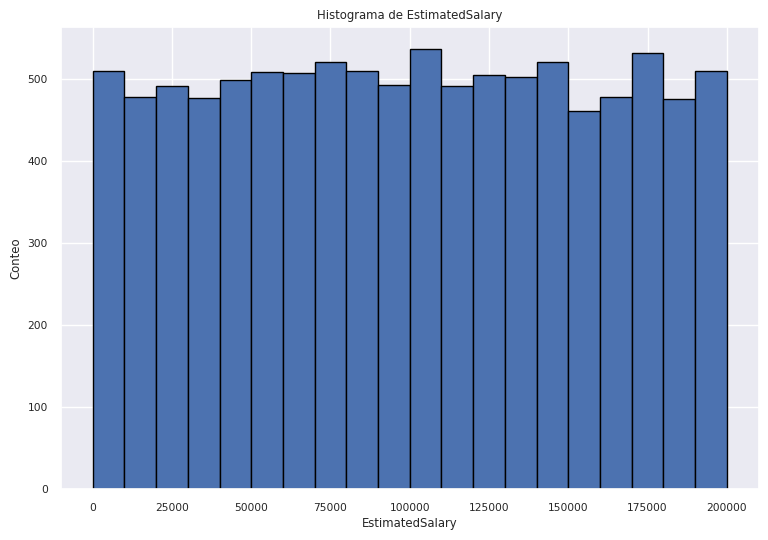

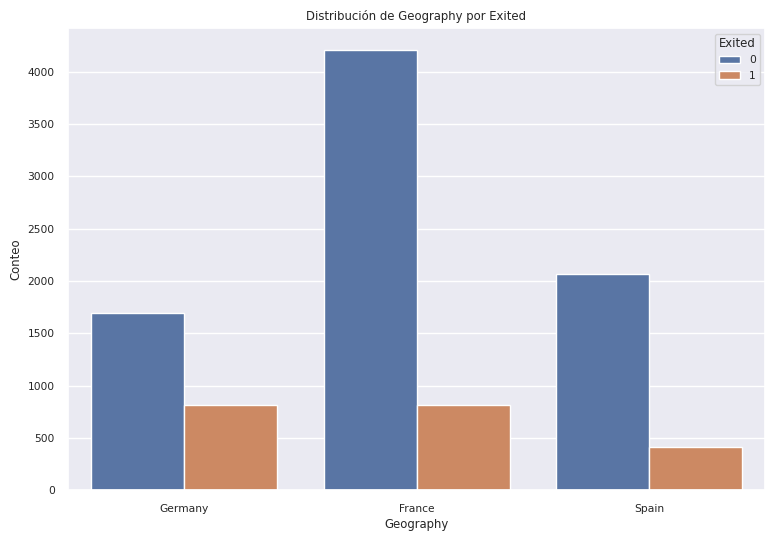

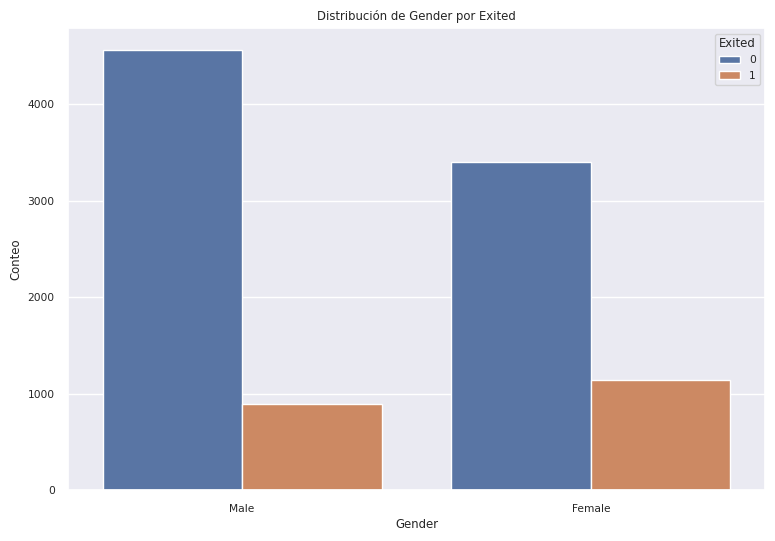

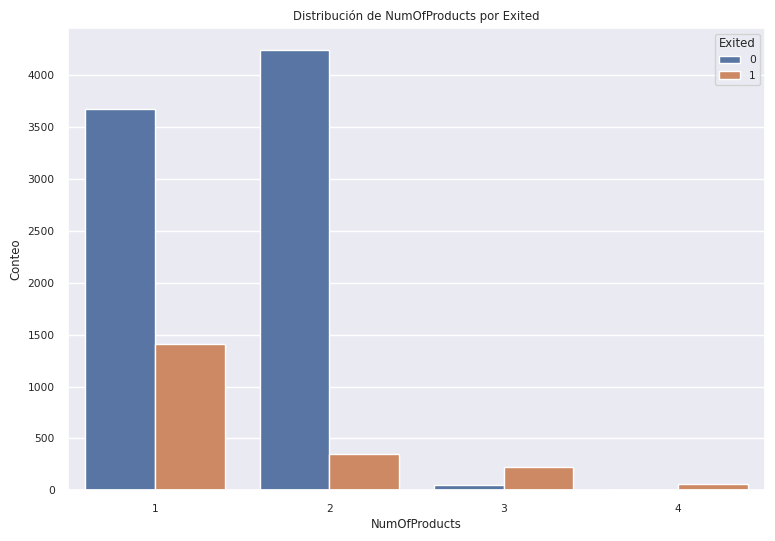

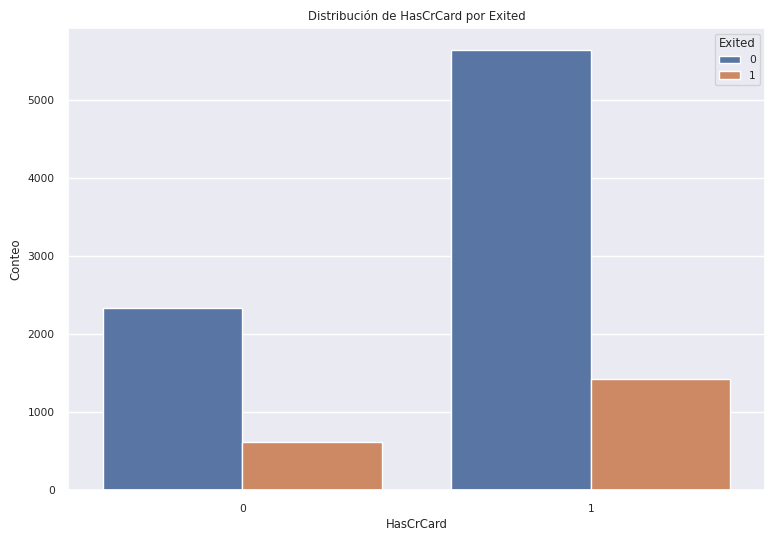

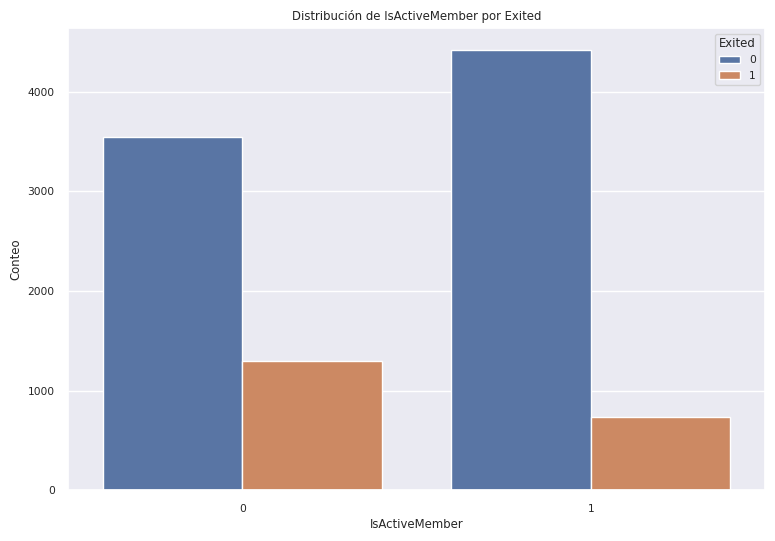

Los gráficos se han mostrado en el notebook. Guarda cada gráfico manualmente haciendo clic derecho sobre ellos y seleccionando 'Guardar imagen como...' en tu máquina local (por ejemplo, en C:\Users\hello\Downloads\). Luego, súbelos a Files/results/ en Fabric.


In [30]:
# Generar y descargar gráficos del Bloque 5 directamente a tu máquina local

import seaborn as sns
import matplotlib.pyplot as plt
import os

# Configurar estilo visual
sns.set_theme(style="whitegrid", palette="tab10", rc={'figure.figsize':(9,6)})
sns.set(font_scale=0.7)

# Cargar df_clean para generar los gráficos
df_clean = spark.read.format("delta").load("Tables/df_clean").toPandas()

# Variables numéricas y categóricas
numeric_variables = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
categorical_variables = ['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
df_num_cols = df_clean[numeric_variables]

# Crear boxplots para variables numéricas
for col in df_num_cols.columns:
    plt.figure(figsize=(9,6))
    sns.boxplot(x=df_num_cols[col], color='green')
    plt.title(f'Boxplot de {col}')
    plt.xlabel(col)
    plt.show()

# Crear histogramas para variables numéricas
for col in df_num_cols.columns:
    plt.figure(figsize=(9,6))
    df_num_cols[col].hist(bins=20, edgecolor='black')
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Conteo')
    plt.show()

# Convertir Exited a string para evitar el error con sns.countplot
df_clean['Exited'] = df_clean['Exited'].astype(str)

# Visualizar distribución de Exited en variables categóricas
for var in categorical_variables:
    plt.figure(figsize=(9,6))
    sns.countplot(x=var, hue=df_clean['Exited'], data=df_clean)
    plt.title(f'Distribución de {var} por Exited')
    plt.xlabel(var)
    plt.ylabel('Conteo')
    plt.show()

print("Los gráficos se han mostrado en el notebook. Guarda cada gráfico manualmente haciendo clic derecho sobre ellos y seleccionando 'Guardar imagen como...' en tu máquina local (por ejemplo, en C:\\Users\\hello\\Downloads\\). Luego, súbelos a Files/results/ en Fabric.")